# Simple XGBoost Analysis
* Data: [Adult Data Set](https://archive.ics.uci.edu/ml/datasets/Adult) from UCI Machine Learning Repository
* Link: [Adult data](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/)

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

warnings.simplefilter('ignore')
%matplotlib inline

print('Scikit-learn:\t', sklearn.__version__)
print('Numpy:\t\t', np.__version__)
print('Pandas:\t\t', pd.__version__)
print('Matplotlib:\t', mpl.__version__)
print('XGBoost:\t', xgb.__version__)

Scikit-learn:	 0.19.0
Numpy:		 1.13.3
Pandas:		 0.20.3
Matplotlib:	 2.0.2
XGBoost:	 0.6


## Read Data

In [3]:
names = ['age', 'workclass', 'fnlwget', 'education', 'education-num', 
         'marital-status', 'occupation','relation', 'race', 'sex', 
         'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'target']
train = pd.read_csv('./data/Adult/adult.data', header=None, names=names, na_values=' ?')
test = pd.read_csv('./data/Adult/adult.test', header=None, names=names, skiprows=1, na_values=' ?')

In [4]:
train.head()

,age,workclass,fnlwget,education,education-num,marital-status,occupation,relation,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Exploratory Data Analysis

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         30725 non-null object
fnlwget           32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        30718 non-null object
relation          32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    31978 non-null object
target            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [6]:
# missing values
train.isnull().sum()

age                  0
workclass         1836
fnlwget              0
education            0
education-num        0
marital-status       0
occupation        1843
relation             0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
target               0
dtype: int64

In [7]:
test.isnull().sum()

age                 0
workclass         963
fnlwget             0
education           0
education-num       0
marital-status      0
occupation        966
relation            0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
target              0
dtype: int64

## Feature Engineering

In [8]:
# fill missing value with string 'missing'
train.loc[train['workclass'].isnull(), 'workclass'] = 'missing'
test.loc[test['workclass'].isnull(), 'workclass'] = 'missing'

train.loc[train['occupation'].isnull(), 'occupation'] = 'missing'
test.loc[test['occupation'].isnull(), 'occupation'] = 'missing'

train.loc[train['native-country'].isnull(), 'native-country'] = 'missing'
test.loc[test['native-country'].isnull(), 'native-country'] = 'missing'

In [9]:
# categorical and numerical features
cat_feature = ['workclass', 'education', 'marital-status', 'occupation', 'relation', 'race', 'sex', 'native-country']
num_feature = ['age', 'fnlwget', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

In [10]:
# trim the space for categorical features
for name in cat_feature + ['target']:
    train[name] = train[name].apply(lambda x: x.strip())
    test[name] = test[name].apply(lambda x: x.strip())

In [11]:
# transform target values
print('train:\t', train['target'].unique())
print('test:\t', test['target'].unique())

# transform into binary
train_tr = train['target'].apply(lambda x: 0 if x == '<=50K' else 1).values
test_tr = test['target'].apply(lambda x: 0 if x == '<=50K.' else 1).values

train:	 ['<=50K' '>50K']
test:	 ['<=50K.' '>50K.']


In [12]:
# drop target values
train = train.drop('target', axis=1)
test = test.drop('target', axis=1)

In [13]:
# transform sex values
print('train:\t', train['sex'].unique())
print('test:\t', test['sex'].unique())

# transform into binary
train['sex'] = train['sex'].apply(lambda x: 0 if x == 'Male' else 1)
test['sex'] = test['sex'].apply(lambda x: 0 if x == 'Male' else 1)

train:	 ['Male' 'Female']
test:	 ['Male' 'Female']


In [14]:
# merget data together for better processing
data = pd.concat([train, test])
data.head()

,age,workclass,fnlwget,education,education-num,marital-status,occupation,relation,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,0,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,0,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,0,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,0,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,1,0,0,40,Cuba


In [15]:
# categorical and numerical features
cat_feature = ['workclass', 'education', 'marital-status', 'occupation', 'relation', 'race', 'native-country']
num_feature = ['age', 'fnlwget', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']

# One-hot encoding categorical features
tmp = pd.get_dummies(data[cat_feature])
dummy_data = pd.concat([data[num_feature], tmp], axis=1)
dummy_data.shape

(48842, 107)

In [16]:
dummy_data.head()

,age,fnlwget,education-num,sex,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,native-country_missing
0,39,77516,13,0,2174,0,40,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,50,83311,13,0,0,0,13,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38,215646,9,0,0,0,40,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,53,234721,7,0,0,0,40,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,28,338409,13,1,0,0,40,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# get encoded train and test data
train_x = dummy_data[:len(train)]
test_x = dummy_data[len(train):]

## Fit Models

In [18]:
# transform into XGBoost matrix
dtrain = xgb.DMatrix(train_x, label=train_tr)
dtest = xgb.DMatrix(test_x, label=test_tr)

### 1. default parameters

In [19]:
# specify default parameters via map
params = {'booster': 'gbtree', 'silent': 1, 'eta': 0.3, 'gamma': 0, 
          'max_depth': 6, 'objective': 'binary:logistic', 'min_child_weight': 1, 
          'subsample': 1, 'colsample_bytree': 1}

# train XGBoost model through cross validation
xgbcv = xgb.cv(params=params, dtrain=dtrain, num_boost_round=100, nfold=5, 
               stratified=True, metrics=('error', 'auc'), maximize=False, 
               early_stopping_rounds=20, verbose_eval=10, show_stdv=True)

[0]	train-auc:0.896883+0.00171169	train-error:0.144083+0.00125659	test-auc:0.892216+0.00344815	test-error:0.146433+0.00426696
[10]	train-auc:0.926793+0.000783143	train-error:0.131069+0.00139931	test-auc:0.918369+0.00263339	test-error:0.136513+0.00337227
[20]	train-auc:0.938113+0.000531638	train-error:0.120105+0.000972714	test-auc:0.924731+0.0034229	test-error:0.129449+0.00311889
[30]	train-auc:0.943373+0.00061128	train-error:0.114662+0.000763151	test-auc:0.927347+0.00349501	test-error:0.127729+0.00319897
[40]	train-auc:0.947109+0.000678717	train-error:0.110907+0.00102941	test-auc:0.927984+0.00365094	test-error:0.127177+0.00352948
[50]	train-auc:0.9502+0.000800588	train-error:0.107606+0.00128933	test-auc:0.928361+0.00355265	test-error:0.126624+0.00335598
[60]	train-auc:0.952947+0.000369414	train-error:0.104957+0.0010491	test-auc:0.928362+0.00365134	test-error:0.126378+0.0029566
[70]	train-auc:0.955337+0.000804032	train-error:0.102323+0.00171614	test-auc:0.928512+0.00365248	test-error:0.

In [20]:
xgbcv.head()

,test-auc-mean,test-auc-std,test-error-mean,test-error-std,train-auc-mean,train-auc-std,train-error-mean,train-error-std
0,0.892216,0.003448,0.146433,0.004267,0.896883,0.001712,0.144083,0.001257
1,0.901418,0.003246,0.144682,0.004246,0.906158,0.000757,0.142080,0.001684
2,0.906077,0.002571,0.143700,0.004435,0.911166,0.000758,0.140828,0.000892
3,0.909187,0.002410,0.141888,0.004428,0.914060,0.000662,0.139699,0.001375
4,0.910926,0.002201,0.140198,0.004102,0.916093,0.000741,0.137772,0.001136


In [21]:
len(xgbcv)

65

In [22]:
min(xgbcv['test-error-mean'])

0.125948

### 2. re-train model with best iteration

In [23]:
params = {'booster': 'gbtree', 'silent': 1, 'eta': 0.3, 'gamma': 0, 
          'max_depth': 6, 'objective': 'binary:logistic', 'min_child_weight': 1, 
          'subsample': 1, 'colsample_bytree': 1, 'eval_metric': ['error', 'auc']}

xgb1 = xgb.train(params=params, dtrain=dtrain, num_boost_round=65, maximize=False, 
                 evals=[(dtrain, 'train'), (dtest, 'eval')], early_stopping_rounds=10, 
                 verbose_eval=10)
xgb1_pred = xgb1.predict(dtest)

[0]	train-error:0.144805	train-auc:0.897748	eval-error:0.143726	eval-auc:0.89424
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 10 rounds.
[10]	train-error:0.131876	train-auc:0.926587	eval-error:0.13181	eval-auc:0.919093
[20]	train-error:0.121864	train-auc:0.936592	eval-error:0.126651	eval-auc:0.924082
[30]	train-error:0.115936	train-auc:0.94218	eval-error:0.124931	eval-auc:0.927265
[40]	train-error:0.112251	train-auc:0.94544	eval-error:0.124992	eval-auc:0.927603
[50]	train-error:0.109303	train-auc:0.948183	eval-error:0.125238	eval-auc:0.928142
[60]	train-error:0.106354	train-auc:0.950966	eval-error:0.124808	eval-auc:0.928428


In [24]:
# binary classification
xgb1_label = (xgb1_pred > 0.5).astype(int)
confusion_matrix(test_tr, xgb1_label)

array([[11731,   704],
       [ 1320,  2526]])

In [25]:
accuracy_score(test_tr, xgb1_label)

0.87568331183588233

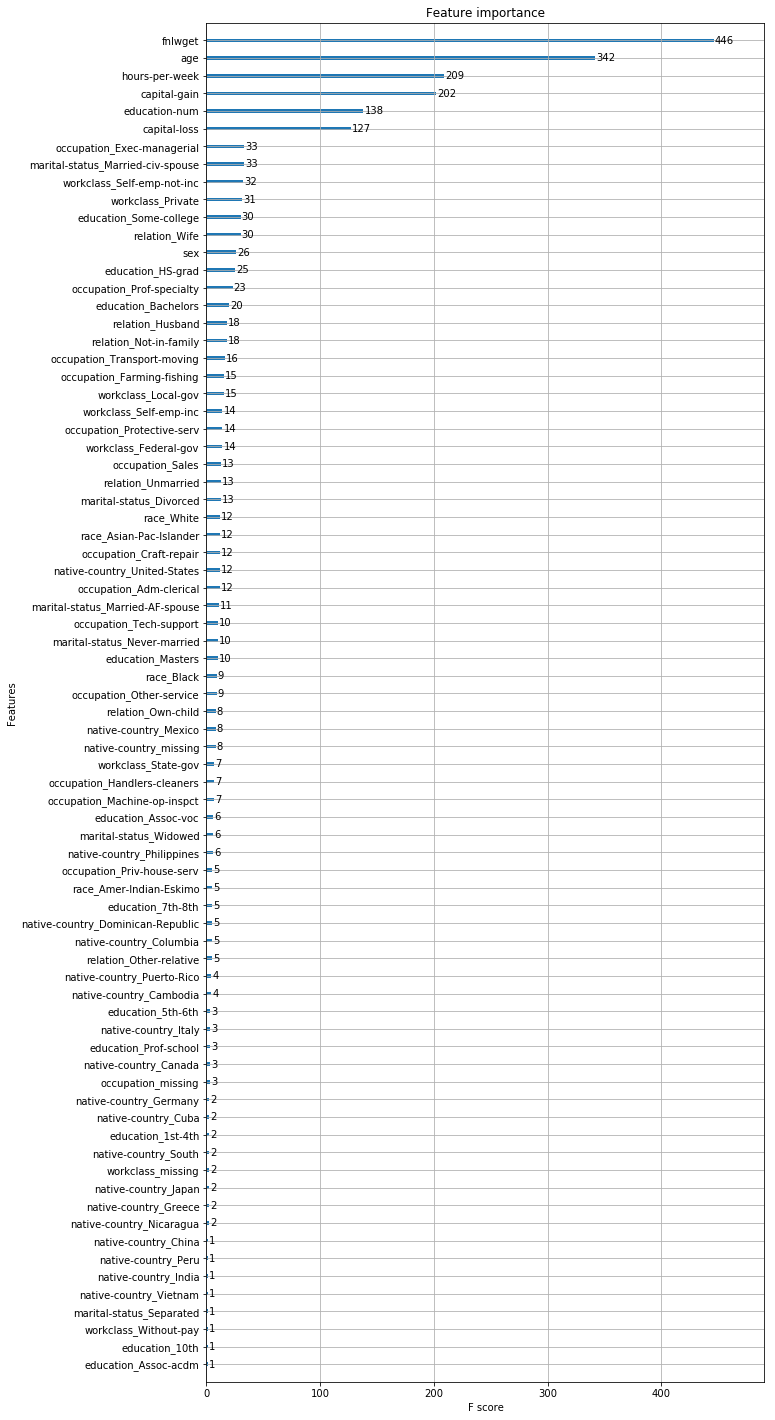

In [27]:
# feature importance
fig, ax = plt.subplots(figsize=(10, 25))
xgb.plot_importance(xgb1, ax=ax)
plt.show()

### 3. Grid Search CV

In [34]:
gbm = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, silent=True, 
                        objective='binary:logistic', gamma=0)
params = {
    'max_depth': [3, 5], 
    'min_child_weight': [1, 3],
    'subsample': [0.5, 0.7, 1.0], 
    'colsample_bytree': [0.5, 0.7, 1.0]
}

grid = GridSearchCV(estimator=gbm, param_grid=params, scoring='accuracy', 
                    n_jobs=4, cv=5, verbose=10)
grid.fit(train_x, train_tr)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] subsample=0.5, min_child_weight=1, max_depth=3, colsample_bytree=0.5 
[CV] subsample=0.5, min_child_weight=1, max_depth=3, colsample_bytree=0.5 
[CV] subsample=0.5, min_child_weight=1, max_depth=3, colsample_bytree=0.5 
[CV] subsample=0.5, min_child_weight=1, max_depth=3, colsample_bytree=0.5 
[CV]  subsample=0.5, min_child_weight=1, max_depth=3, colsample_bytree=0.5, score=0.8617936117936118, total=   4.1s
[CV]  subsample=0.5, min_child_weight=1, max_depth=3, colsample_bytree=0.5, score=0.8642506142506142, total=   4.1s
[CV]  subsample=0.5, min_child_weight=1, max_depth=3, colsample_bytree=0.5, score=0.8581298940580377, total=   4.2s
[CV]  subsample=0.5, min_child_weight=1, max_depth=3, colsample_bytree=0.5, score=0.8687039312039312, total=   4.1s
[CV] subsample=0.5, min_child_weight=1, max_depth=3, colsample_bytree=0.5 
[CV] subsample=0.7, min_child_weight=1, max_depth=3, colsample_bytree=0.5 
[CV] subsample=0.7, min_

[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    8.3s


[CV]  subsample=0.5, min_child_weight=1, max_depth=3, colsample_bytree=0.5, score=0.8687039312039312, total=   4.1s
[CV] subsample=1.0, min_child_weight=1, max_depth=3, colsample_bytree=0.5 
[CV]  subsample=1.0, min_child_weight=1, max_depth=3, colsample_bytree=0.5, score=0.8618148318747121, total=   2.9s
[CV] subsample=1.0, min_child_weight=1, max_depth=3, colsample_bytree=0.5 
[CV]  subsample=1.0, min_child_weight=1, max_depth=3, colsample_bytree=0.5, score=0.8619471744471745, total=   2.8s
[CV] subsample=1.0, min_child_weight=1, max_depth=3, colsample_bytree=0.5 


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   11.7s


[CV]  subsample=0.7, min_child_weight=1, max_depth=3, colsample_bytree=0.5, score=0.8696253071253072, total=   3.7s
[CV]  subsample=0.7, min_child_weight=1, max_depth=3, colsample_bytree=0.5, score=0.8680896805896806, total=   3.7s
[CV] subsample=1.0, min_child_weight=1, max_depth=3, colsample_bytree=0.5 
[CV] subsample=0.5, min_child_weight=3, max_depth=3, colsample_bytree=0.5 
[CV]  subsample=1.0, min_child_weight=1, max_depth=3, colsample_bytree=0.5, score=0.8659398034398035, total=   2.8s
[CV] subsample=0.5, min_child_weight=3, max_depth=3, colsample_bytree=0.5 
[CV]  subsample=1.0, min_child_weight=1, max_depth=3, colsample_bytree=0.5, score=0.8667076167076168, total=   2.8s
[CV] subsample=0.5, min_child_weight=3, max_depth=3, colsample_bytree=0.5 
[CV]  subsample=1.0, min_child_weight=1, max_depth=3, colsample_bytree=0.5, score=0.867014742014742, total=   2.9s
[CV] subsample=0.5, min_child_weight=3, max_depth=3, colsample_bytree=0.5 
[CV]  subsample=0.5, min_child_weight=3, max_d

[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   18.7s


[CV]  subsample=0.5, min_child_weight=3, max_depth=3, colsample_bytree=0.5, score=0.8636363636363636, total=   4.2s
[CV] subsample=0.7, min_child_weight=3, max_depth=3, colsample_bytree=0.5 
[CV]  subsample=0.5, min_child_weight=3, max_depth=3, colsample_bytree=0.5, score=0.867014742014742, total=   4.0s
[CV] subsample=0.7, min_child_weight=3, max_depth=3, colsample_bytree=0.5 
[CV]  subsample=0.5, min_child_weight=3, max_depth=3, colsample_bytree=0.5, score=0.8676289926289926, total=   4.0s
[CV] subsample=0.7, min_child_weight=3, max_depth=3, colsample_bytree=0.5 
[CV]  subsample=0.7, min_child_weight=3, max_depth=3, colsample_bytree=0.5, score=0.8572086596038692, total=   3.7s
[CV] subsample=0.7, min_child_weight=3, max_depth=3, colsample_bytree=0.5 
[CV]  subsample=0.7, min_child_weight=3, max_depth=3, colsample_bytree=0.5, score=0.8621007371007371, total=   3.6s
[CV] subsample=1.0, min_child_weight=3, max_depth=3, colsample_bytree=0.5 
[CV]  subsample=0.7, min_child_weight=3, max_d

[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   24.6s


[CV]  subsample=1.0, min_child_weight=3, max_depth=3, colsample_bytree=0.5, score=0.8602794411177644, total=   3.0s
[CV] subsample=1.0, min_child_weight=3, max_depth=3, colsample_bytree=0.5 
[CV]  subsample=1.0, min_child_weight=3, max_depth=3, colsample_bytree=0.5, score=0.8611793611793612, total=   3.0s
[CV] subsample=1.0, min_child_weight=3, max_depth=3, colsample_bytree=0.5 
[CV]  subsample=0.7, min_child_weight=3, max_depth=3, colsample_bytree=0.5, score=0.8682432432432432, total=   3.9s
[CV] subsample=0.5, min_child_weight=1, max_depth=5, colsample_bytree=0.5 
[CV]  subsample=1.0, min_child_weight=3, max_depth=3, colsample_bytree=0.5, score=0.8657862407862408, total=   3.0s
[CV] subsample=0.5, min_child_weight=1, max_depth=5, colsample_bytree=0.5 
[CV]  subsample=1.0, min_child_weight=3, max_depth=3, colsample_bytree=0.5, score=0.8659398034398035, total=   3.0s
[CV] subsample=0.5, min_child_weight=1, max_depth=5, colsample_bytree=0.5 
[CV]  subsample=1.0, min_child_weight=3, max_

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   36.3s


[CV]  subsample=0.5, min_child_weight=1, max_depth=5, colsample_bytree=0.5, score=0.8753071253071253, total=   7.0s
[CV] subsample=0.7, min_child_weight=1, max_depth=5, colsample_bytree=0.5 
[CV]  subsample=0.5, min_child_weight=1, max_depth=5, colsample_bytree=0.5, score=0.8737714987714987, total=   6.8s
[CV] subsample=0.7, min_child_weight=1, max_depth=5, colsample_bytree=0.5 
[CV]  subsample=0.7, min_child_weight=1, max_depth=5, colsample_bytree=0.5, score=0.8681099339781975, total=   6.0s
[CV] subsample=0.7, min_child_weight=1, max_depth=5, colsample_bytree=0.5 
[CV]  subsample=0.7, min_child_weight=1, max_depth=5, colsample_bytree=0.5, score=0.8691646191646192, total=   5.8s
[CV] subsample=1.0, min_child_weight=1, max_depth=5, colsample_bytree=0.5 
[CV]  subsample=0.7, min_child_weight=1, max_depth=5, colsample_bytree=0.5, score=0.8723894348894349, total=   5.8s
[CV] subsample=1.0, min_child_weight=1, max_depth=5, colsample_bytree=0.5 
[CV]  subsample=0.7, min_child_weight=1, max_

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   47.7s


[CV]  subsample=1.0, min_child_weight=1, max_depth=5, colsample_bytree=0.5, score=0.8711609336609336, total=   4.6s
[CV] subsample=0.5, min_child_weight=3, max_depth=5, colsample_bytree=0.5 
[CV]  subsample=1.0, min_child_weight=1, max_depth=5, colsample_bytree=0.5, score=0.8722358722358723, total=   4.6s
[CV]  subsample=1.0, min_child_weight=1, max_depth=5, colsample_bytree=0.5, score=0.8736179361179361, total=   4.6s
[CV] subsample=0.5, min_child_weight=3, max_depth=5, colsample_bytree=0.5 
[CV] subsample=0.5, min_child_weight=3, max_depth=5, colsample_bytree=0.5 
[CV]  subsample=0.5, min_child_weight=3, max_depth=5, colsample_bytree=0.5, score=0.8682634730538922, total=   6.7s
[CV] subsample=0.5, min_child_weight=3, max_depth=5, colsample_bytree=0.5 
[CV]  subsample=0.5, min_child_weight=3, max_depth=5, colsample_bytree=0.5, score=0.8676289926289926, total=   6.6s
[CV] subsample=0.7, min_child_weight=3, max_depth=5, colsample_bytree=0.5 
[CV]  subsample=0.5, min_child_weight=3, max_

[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  1.1min


[CV]  subsample=0.7, min_child_weight=3, max_depth=5, colsample_bytree=0.5, score=0.8756142506142506, total=   6.0s
[CV] subsample=1.0, min_child_weight=3, max_depth=5, colsample_bytree=0.5 
[CV]  subsample=1.0, min_child_weight=3, max_depth=5, colsample_bytree=0.5, score=0.8693181818181818, total=   4.4s
[CV]  subsample=1.0, min_child_weight=3, max_depth=5, colsample_bytree=0.5, score=0.869031168432366, total=   4.5s
[CV] subsample=1.0, min_child_weight=3, max_depth=5, colsample_bytree=0.5 
[CV] subsample=1.0, min_child_weight=3, max_depth=5, colsample_bytree=0.5 
[CV]  subsample=0.7, min_child_weight=3, max_depth=5, colsample_bytree=0.5, score=0.8725429975429976, total=   5.9s
[CV] subsample=0.5, min_child_weight=1, max_depth=3, colsample_bytree=0.7 
[CV]  subsample=1.0, min_child_weight=3, max_depth=5, colsample_bytree=0.5, score=0.8716216216216216, total=   4.5s
[CV] subsample=0.5, min_child_weight=1, max_depth=3, colsample_bytree=0.7 
[CV]  subsample=1.0, min_child_weight=3, max_d

[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  1.3min


[CV]  subsample=0.5, min_child_weight=1, max_depth=3, colsample_bytree=0.7, score=0.8674754299754299, total=   5.7s
[CV] subsample=0.7, min_child_weight=1, max_depth=3, colsample_bytree=0.7 
[CV]  subsample=0.7, min_child_weight=1, max_depth=3, colsample_bytree=0.7, score=0.8582834331337326, total=   5.2s
[CV] subsample=0.7, min_child_weight=1, max_depth=3, colsample_bytree=0.7 
[CV]  subsample=0.7, min_child_weight=1, max_depth=3, colsample_bytree=0.7, score=0.8605651105651105, total=   5.1s
[CV] subsample=1.0, min_child_weight=1, max_depth=3, colsample_bytree=0.7 
[CV]  subsample=0.7, min_child_weight=1, max_depth=3, colsample_bytree=0.7, score=0.8636363636363636, total=   5.1s
[CV] subsample=1.0, min_child_weight=1, max_depth=3, colsample_bytree=0.7 
[CV]  subsample=0.7, min_child_weight=1, max_depth=3, colsample_bytree=0.7, score=0.8651719901719902, total=   5.1s
[CV] subsample=1.0, min_child_weight=1, max_depth=3, colsample_bytree=0.7 
[CV]  subsample=0.7, min_child_weight=1, max_

[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  1.6min


[CV]  subsample=0.5, min_child_weight=3, max_depth=3, colsample_bytree=0.7, score=0.8640970515970516, total=   5.9s
[CV] subsample=0.7, min_child_weight=3, max_depth=3, colsample_bytree=0.7 
[CV]  subsample=0.5, min_child_weight=3, max_depth=3, colsample_bytree=0.7, score=0.8660933660933661, total=   5.8s
[CV] subsample=0.7, min_child_weight=3, max_depth=3, colsample_bytree=0.7 
[CV]  subsample=0.5, min_child_weight=3, max_depth=3, colsample_bytree=0.7, score=0.8673218673218673, total=   5.6s
[CV] subsample=0.7, min_child_weight=3, max_depth=3, colsample_bytree=0.7 
[CV]  subsample=0.7, min_child_weight=3, max_depth=3, colsample_bytree=0.7, score=0.8592046675879011, total=   5.1s
[CV] subsample=0.7, min_child_weight=3, max_depth=3, colsample_bytree=0.7 
[CV]  subsample=0.7, min_child_weight=3, max_depth=3, colsample_bytree=0.7, score=0.8610257985257985, total=   5.1s
[CV] subsample=1.0, min_child_weight=3, max_depth=3, colsample_bytree=0.7 
[CV]  subsample=0.7, min_child_weight=3, max_

[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  1.9min


[CV]  subsample=0.5, min_child_weight=1, max_depth=5, colsample_bytree=0.7, score=0.8661139259941655, total=  10.1s
[CV] subsample=0.5, min_child_weight=1, max_depth=5, colsample_bytree=0.7 
[CV]  subsample=0.5, min_child_weight=1, max_depth=5, colsample_bytree=0.7, score=0.8693181818181818, total=  10.1s
[CV] subsample=0.7, min_child_weight=1, max_depth=5, colsample_bytree=0.7 
[CV]  subsample=0.5, min_child_weight=1, max_depth=5, colsample_bytree=0.7, score=0.8728501228501229, total=  10.0s
[CV] subsample=0.7, min_child_weight=1, max_depth=5, colsample_bytree=0.7 
[CV]  subsample=0.5, min_child_weight=1, max_depth=5, colsample_bytree=0.7, score=0.8737714987714987, total=  10.0s
[CV] subsample=0.7, min_child_weight=1, max_depth=5, colsample_bytree=0.7 
[CV]  subsample=0.5, min_child_weight=1, max_depth=5, colsample_bytree=0.7, score=0.8699324324324325, total=   9.2s
[CV] subsample=0.7, min_child_weight=1, max_depth=5, colsample_bytree=0.7 
[CV]  subsample=0.7, min_child_weight=1, max_

[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  2.4min


[CV]  subsample=0.5, min_child_weight=3, max_depth=5, colsample_bytree=0.7, score=0.8688776293566712, total=   9.0s
[CV] subsample=0.5, min_child_weight=3, max_depth=5, colsample_bytree=0.7 
[CV]  subsample=0.5, min_child_weight=3, max_depth=5, colsample_bytree=0.7, score=0.8679361179361179, total=   8.7s
[CV] subsample=0.7, min_child_weight=3, max_depth=5, colsample_bytree=0.7 
[CV]  subsample=0.5, min_child_weight=3, max_depth=5, colsample_bytree=0.7, score=0.8723894348894349, total=   8.7s
[CV] subsample=0.7, min_child_weight=3, max_depth=5, colsample_bytree=0.7 
[CV]  subsample=0.5, min_child_weight=3, max_depth=5, colsample_bytree=0.7, score=0.8739250614250614, total=   8.7s
[CV] subsample=0.7, min_child_weight=3, max_depth=5, colsample_bytree=0.7 
[CV]  subsample=0.5, min_child_weight=3, max_depth=5, colsample_bytree=0.7, score=0.8723894348894349, total=   8.8s
[CV] subsample=0.7, min_child_weight=3, max_depth=5, colsample_bytree=0.7 
[CV]  subsample=0.7, min_child_weight=3, max_

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  2.9min


[CV]  subsample=0.5, min_child_weight=1, max_depth=3, colsample_bytree=1.0, score=0.8607400583448488, total=   7.6s
[CV] subsample=0.5, min_child_weight=1, max_depth=3, colsample_bytree=1.0 
[CV]  subsample=0.5, min_child_weight=1, max_depth=3, colsample_bytree=1.0, score=0.8625614250614251, total=   7.5s
[CV] subsample=0.7, min_child_weight=1, max_depth=3, colsample_bytree=1.0 
[CV]  subsample=0.5, min_child_weight=1, max_depth=3, colsample_bytree=1.0, score=0.8690110565110565, total=   7.5s
[CV]  subsample=0.5, min_child_weight=1, max_depth=3, colsample_bytree=1.0, score=0.8642506142506142, total=   7.5s
[CV] subsample=0.7, min_child_weight=1, max_depth=3, colsample_bytree=1.0 
[CV] subsample=0.7, min_child_weight=1, max_depth=3, colsample_bytree=1.0 
[CV]  subsample=0.5, min_child_weight=1, max_depth=3, colsample_bytree=1.0, score=0.8671683046683046, total=   7.6s
[CV] subsample=0.7, min_child_weight=1, max_depth=3, colsample_bytree=1.0 
[CV]  subsample=0.7, min_child_weight=1, max_

[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  3.4min


[CV]  subsample=0.5, min_child_weight=3, max_depth=3, colsample_bytree=1.0, score=0.8630221130221131, total=   7.3s
[CV] subsample=0.7, min_child_weight=3, max_depth=3, colsample_bytree=1.0 
[CV]  subsample=0.5, min_child_weight=3, max_depth=3, colsample_bytree=1.0, score=0.8688574938574939, total=   7.2s
[CV] subsample=0.7, min_child_weight=3, max_depth=3, colsample_bytree=1.0 
[CV]  subsample=0.5, min_child_weight=3, max_depth=3, colsample_bytree=1.0, score=0.8659398034398035, total=   7.3s
[CV] subsample=0.7, min_child_weight=3, max_depth=3, colsample_bytree=1.0 
[CV]  subsample=0.7, min_child_weight=3, max_depth=3, colsample_bytree=1.0, score=0.8598188238906802, total=   6.8s
[CV] subsample=0.7, min_child_weight=3, max_depth=3, colsample_bytree=1.0 
[CV]  subsample=0.7, min_child_weight=3, max_depth=3, colsample_bytree=1.0, score=0.8616400491400491, total=   6.9s
[CV] subsample=1.0, min_child_weight=3, max_depth=3, colsample_bytree=1.0 
[CV]  subsample=0.7, min_child_weight=3, max_

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  4.0min


[CV]  subsample=0.5, min_child_weight=1, max_depth=5, colsample_bytree=1.0, score=0.8717751842751843, total=  13.1s
[CV] subsample=0.7, min_child_weight=1, max_depth=5, colsample_bytree=1.0 
[CV]  subsample=0.7, min_child_weight=1, max_depth=5, colsample_bytree=1.0, score=0.8648856133886074, total=  11.8s
[CV] subsample=0.7, min_child_weight=1, max_depth=5, colsample_bytree=1.0 
[CV]  subsample=0.7, min_child_weight=1, max_depth=5, colsample_bytree=1.0, score=0.8671683046683046, total=  11.6s
[CV] subsample=1.0, min_child_weight=1, max_depth=5, colsample_bytree=1.0 
[CV]  subsample=0.7, min_child_weight=1, max_depth=5, colsample_bytree=1.0, score=0.871468058968059, total=  11.5s
[CV] subsample=1.0, min_child_weight=1, max_depth=5, colsample_bytree=1.0 
[CV]  subsample=0.7, min_child_weight=1, max_depth=5, colsample_bytree=1.0, score=0.875, total=  10.8s
[CV] subsample=1.0, min_child_weight=1, max_depth=5, colsample_bytree=1.0 
[CV]  subsample=1.0, min_child_weight=1, max_depth=5, colsa

[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:  4.8min


[CV]  subsample=0.7, min_child_weight=3, max_depth=5, colsample_bytree=1.0, score=0.8720823095823096, total=  10.1s
[CV] subsample=1.0, min_child_weight=3, max_depth=5, colsample_bytree=1.0 
[CV]  subsample=1.0, min_child_weight=3, max_depth=5, colsample_bytree=1.0, score=0.8685705512052817, total=   7.6s
[CV] subsample=1.0, min_child_weight=3, max_depth=5, colsample_bytree=1.0 
[CV]  subsample=1.0, min_child_weight=3, max_depth=5, colsample_bytree=1.0, score=0.8668611793611793, total=   7.5s
[CV] subsample=1.0, min_child_weight=3, max_depth=5, colsample_bytree=1.0 
[CV]  subsample=0.7, min_child_weight=3, max_depth=5, colsample_bytree=1.0, score=0.8734643734643734, total=  10.3s
[CV]  subsample=1.0, min_child_weight=3, max_depth=5, colsample_bytree=1.0, score=0.8708538083538083, total=   7.7s
[CV]  subsample=1.0, min_child_weight=3, max_depth=5, colsample_bytree=1.0, score=0.8737714987714987, total=   7.4s
[CV]  subsample=1.0, min_child_weight=3, max_depth=5, colsample_bytree=1.0, sco

[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:  5.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'subsample': [0.5, 0.7, 1.0], 'min_child_weight': [1, 3], 'max_depth': [3, 5], 'colsample_bytree': [0.5, 0.7, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=10)

In [42]:
# best parameters and best score
grid.best_score_

0.87184054543779366

In [36]:
grid.best_params_

{'colsample_bytree': 0.5,
 'max_depth': 5,
 'min_child_weight': 1,
 'subsample': 0.5}

In [37]:
# make prediction using the best estimator
train_grid_pred = grid.best_estimator_.predict(train_x)
test_grid_pred = grid.best_estimator_.predict(test_x)

In [38]:
# best estimator on training set
confusion_matrix(train_tr, train_grid_pred)

array([[23515,  1205],
       [ 2741,  5100]])

In [39]:
accuracy_score(train_tr, train_grid_pred)

0.87881207579619791

In [40]:
# best estimator on test set
confusion_matrix(test_tr, test_grid_pred)

array([[11779,   656],
       [ 1398,  2448]])

In [41]:
accuracy_score(test_tr, test_grid_pred)

0.87384067317732328